# Data loading & Useful packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn.metrics import accuracy_score, hinge_loss, confusion_matrix  
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.feature_selection import f_classif
from sklearn.model_selection import validation_curve



from google.colab import drive
drive.mount('/content/gdrive')
DRIVE_BASE = '/content/gdrive/My Drive'


training1=pd.read_csv("/content/gdrive/My Drive/data/training1.csv")
training2=pd.read_csv("/content/gdrive/My Drive/data/training2.csv")
test=pd.read_csv("/content/gdrive/My Drive/data/test.csv")
sample_valid_predictions=pd.read_csv("/content/gdrive/My Drive/data/sample_valid_predictions.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#Convert from dataframe to numpy
training1_data = training1.values

training2_data = training2.values
testing_data = test.values
predictions = sample_valid_predictions.values

confidence = np.concatenate([training1_data[:,-1],training2_data[:,-1]]) #Get confidence labels
classes = np.concatenate([training1_data[:,-2],training2_data[:,-2]])  #Get Ground Truth labels

training1_data = training1_data[:,:-2]  #Remove confidence and ground truth labels
training2_data = training2_data[:,:-2]

# Fill in missing data

In [3]:
def delete_missing_data(training_data,threshold=0.22):
  percent_missing = []  #Get the percentage of data missing for each feature

  for i in range(training_data[0].shape[0]):
    empty = 0
    for j in range(training_data[:,0].shape[0]):
      if np.isnan(training_data[j,i]):  #Find if box contains empty variable
        empty+=1  #Increase if found empty box in column
    percent_missing.append(empty/(training_data[:,0].shape[0])) #Calculate percentage

  indexes = []
  for perc in range(len(percent_missing)):
    if percent_missing[perc]>threshold:
      indexes.append(perc)  #Include indexes of data to be removed

  return indexes

In [4]:
indexes_to_remove = delete_missing_data(training2_data,threshold=0.20)  #Take the indexes where the is high missing training data

training2_data[np.isnan(training2_data)] = np.nan #Convert all Nan values to np.nan in order for the KNNImputer to work
imputer = KNNImputer(n_neighbors=10) #Create nearest neighbours from sklearn
training2_data = imputer.fit_transform(training2_data) #Use sklearn nearest neighbours to acquire most common values within nearest neighbours

all_training_nothing_removed = np.concatenate([training1_data,training2_data]) #Concatenate both training data sets without removing any features

training2_data = training2_data[:,indexes_to_remove]  #Remove features from training 1 and training 2 data
training1_data = training1_data[:,indexes_to_remove]

all_training = np.concatenate([training1_data,training2_data])  #Concatenate both training data sets with removed features

# Pre processing 

In [5]:
##Standardization and variance scaling
def rescale(training_data):
  training_data = preprocessing.StandardScaler().fit_transform(training_data) #Rescale data to have 0 mean and unit-variance
  return training_data

In [6]:
##Data normalisation
def normalise(training_data):
  training_data = preprocessing.normalize(training_data, norm='l2') #Normalise data to have Gaussian distribution
  return training_data

In [7]:
##Principle Component Analysis
def princCompAna(n_components,training_data):
  pca = PCA(n_components) #Get the number of components
  training_data = pca.fit_transform(training_data)  #Transform the dimensionality of the data given the number of components
  return training_data

# Model selection

In [8]:
svm.SVC() #Observe the hyperparameters for the classifier Support Vector Machine

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [9]:
#Calcualte accuracy by dividing the amount of correct predictions by all ground truth labels
def calculate_acc(clf,X_test,y_test):
  predicted = clf.predict(X_test) #Predict labels
  correct = 0 #Counter for correctly predicted labels
  i = 0 #Indexes
  for prediction in predicted:  
    if prediction == y_test[i]: #If prediction is correct
      correct+=1  #Add to counter
    i+=1
  return correct/len(y_test)

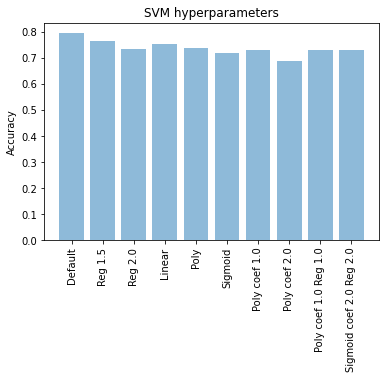

In [10]:
svm_best_hyper = [svm.SVC(),svm.SVC(C=1.5),svm.SVC(C=2),svm.SVC(kernel='linear'),svm.SVC(kernel='poly'),svm.SVC(kernel='sigmoid'),
                  svm.SVC(kernel='poly',coef0=1.0),svm.SVC(kernel='poly',coef0=2.0),svm.SVC(kernel='poly',coef0=1.0,C=1.5),svm.SVC(kernel='sigmoid',coef0=2.0,C=2)] #List of Support Vector machines with different hyperparameters


rescaled_training = rescale(all_training) # Resclale all training data
normalise_training = normalise(rescaled_training) #Normalise the resclaed training data
transformed_training = princCompAna(0.95,normalise_training)  #Transform the trainig data using PCA

kf = KFold(n_splits=10) #Use k fold from sklearn for validation testing
kf.get_n_splits(transformed_training)

i = 0 #index of SVM in list
performance = [] #Store the accuracy of each model in the list
for train_index, test_index in kf.split(transformed_training):  #Do K-fold validation
  X_train, X_test = transformed_training[train_index], transformed_training[test_index]
  y_train, y_test = classes[train_index], classes[test_index]

  svm_best_hyper[i].fit(X_train,y_train,confidence[train_index])  #Pick the confidence labels according to the training labels we have
  performance.append(calculate_acc(svm_best_hyper[i],X_test,y_test))  #Calculate accuracy for each model
  i+=1

objects = ['Default', 'Reg 1.5', 'Reg 2.0', 'Linear', 'Poly','Sigmoid','Poly coef 1.0','Poly coef 2.0','Poly coef 1.0 Reg 1.0','Sigmoid coef 2.0 Reg 2.0']  #Plot bar
y_pos = np.arange(len(objects))
plt.bar(objects, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects,rotation=90)
plt.ylabel('Accuracy')
plt.title('SVM hyperparameters')

plt.show()

# Submission for testing data

In [11]:
#Preprocess the training data
rescaled = rescale(all_training)
normalised = normalise(rescaled)
pca_data = princCompAna(0.95,normalised)

In [12]:
testing_data = testing_data[:,indexes_to_remove]  #Do feature selection of testing data
testing_data[np.isnan(testing_data)] = np.nan #Convert all Nan values to np.nan in order for the KNNImputer to work
imputer = KNNImputer(n_neighbors=10) #Create nearest neighbours from sklearn
testing_data = imputer.fit_transform(testing_data) #Use sklearn nearest neighbours to acquire most common values within nearest neighbours

testing_data = rescale(testing_data)  #Pre process testing data
testing_data = normalise(testing_data)
testing_data = princCompAna(1050,testing_data)

final_classifier = svm.SVC()  #Fit the classifier with the training data and make the prediction for the testing data
final_classifier.fit(pca_data,classes,confidence)
submission = final_classifier.predict(testing_data)

In [13]:
sub = np.asarray(submission)
np.savetxt("/content/gdrive/My Drive" + '/predictions.csv', sub)

# Plots for results

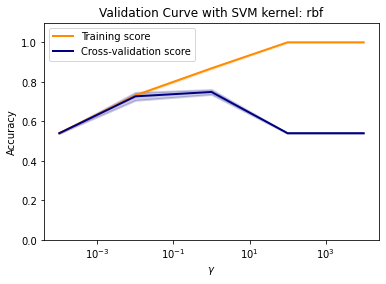

In [14]:
rescaled = rescale(all_training)  #Pre process the data
normalised = normalise(rescaled)
transformed = princCompAna(0.95,normalised)

kf = KFold(n_splits=10) #Perform k-fold cross validation
kf.get_n_splits(transformed)

param_range = np.logspace(-4, 4, 5) #Use code from sklearn see https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py
train_scores, valid_scores = validation_curve(
    svm.SVC(), transformed, classes, param_name="gamma", param_range=param_range,
    scoring="accuracy", n_jobs=1) #Calculate training/validation scores for the training data
train_scores_mean = np.mean(train_scores, axis=1) #Training scores mean
train_scores_std = np.std(train_scores, axis=1) #Training scores standard deviation
valid_scores_mean = np.mean(valid_scores, axis=1) #Validation scores mean
valid_scores_std = np.std(valid_scores, axis=1) #Validation scores standard deviation

plt.title("Validation Curve with SVM kernel: rbf")  #Create plot
plt.xlabel(r"$\gamma$")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Text(0.5, 1.0, 'Amount of features')

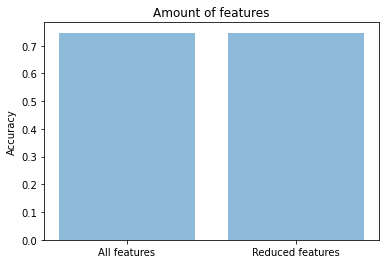

In [15]:
all = svm.SVC() #Create 2 support vector machines
not_all = svm.SVC()

performance =[] #Create array to store performance

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(all_training, classes, test_size=0.33, random_state=42) #Train test split on training data with removed features
all.fit(X_train_all,y_train_all)  #Fit model
performance.append(calculate_acc(all,X_test_all,y_test_all))  #Calcualte model accuracy

X_train_not, X_test_not, y_train_not, y_test_not = train_test_split(all_training_nothing_removed, classes, test_size=0.33, random_state=42) #Train test split on training data without removed features
not_all.fit(X_train_not,y_train_not) #Fit model
performance.append(calculate_acc(not_all,X_test_not,y_test_not)) #Calcualte model accuracy

objects = ['All features', 'Reduced features']  #Plot the results
y_pos = np.arange(len(objects))
plt.bar(objects, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Amount of features')


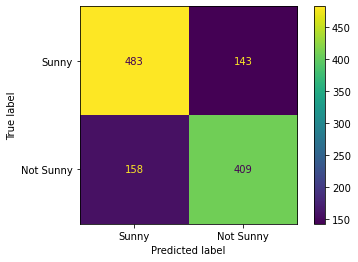

In [16]:
rescaled = rescale(all_training)  #Pre process the data
normalised = normalise(rescaled)
transformed = princCompAna(0.95,normalised)

X_train_indexes, X_test_indexes, y_train_indexes, y_test_indexes = train_test_split(range(0,transformed.shape[0]), range(0,transformed.shape[0]), test_size=0.33, random_state=42) #Train test split to calculate model performance


clf = svm.SVC() #Create support vector machine
clf.fit(transformed[X_train_indexes], classes[y_train_indexes],confidence[X_train_indexes]) #Support Vector Machine prediction
metrics.plot_confusion_matrix(clf, transformed[X_test_indexes], classes[y_test_indexes], display_labels=['Sunny','Not Sunny'],values_format='d') #Plot confusion matrix
